# Imports

In [43]:
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from datetime import datetime

# Let's begin by printing some stats
We will print a random stock.

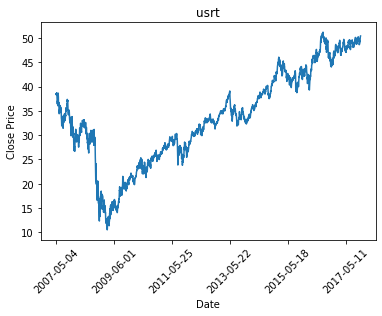

In [44]:
# Set the path
path = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks'
files = os.listdir(path)

# get a random file
random_file = random.choice(files)
df = pd.read_csv(path+'/'+random_file)
df_p = df[['Date', 'Close']]

# Set the date as index
df_p.set_index('Date', inplace=True)

df_p['Close'].plot()
plt.title(random_file.split('.')[0])
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

In [45]:
# Get the min value
min_values = df[['Open', 'Close', 'Low', 'High']].min(axis=1)
min_value = min(min_values)

# Get the row index of the maximum value
row_index_min = min_values.argmin()

# Get the column name of the maximum value
col_name_min = df[['Open', 'Close', 'Low', 'High']].idxmin(axis=1)[row_index_min]
print(f'The minimum value is {min_value}, in column {col_name_min} at row {row_index_min} at {df["Date"][row_index_min]}.')

# Get the max value
max_values = df[['Open', 'Close', 'Low', 'High']].max(axis=1)
max_value = max(max_values)

# Get the row index of the maximum value
row_index = max_values.argmax()

# Get the column name of the maximum value
col_name = df[['Open', 'Close', 'Low', 'High']].idxmax(axis=1)[row_index]
print(f'The maximum value is {max_value}, in column {col_name} at row {row_index} at {df["Date"][row_index]}.')

print(f"\n that's a {((max_value-min_value)/min_value)*100: .3f} % change.")

The minimum value is 9.915, in column Low at row 441 at 2009-03-06.
The maximum value is 51.313, in column Open at row 2304 at 2016-08-01.

 that's a  417.529 % change.


In [46]:
# Create a dictionary with the minimum and maximum values and their corresponding date and volume
min_max_values = {
    "Date_min": df["Date"][row_index_min],
    "Value_min": min_value,
    "Volume": df["Volume"][row_index_min],
    "Date_max": df["Date"][row_index],
    "Value_max": max_value,
    "Perc": ((max_value-min_value)/min_value)*100
}

# Create the DataFrame with the minimum and maximum values
df_min_max = pd.DataFrame(min_max_values, index=[random_file])

df_min_max.head()

,Date_min,Value_min,Volume,Date_max,Value_max,Perc
usrt.us.txt,2009-03-06,9.915,172497,2016-08-01,51.313,417.528996


## Data Parser
A data parser implementation found to be nessecary because of the size of the files. If data is not parsed beforehand then the program becomes extremely slow.

In [47]:
def parser(path):
    '''Given a path it reads all files and appends them in a dictionary
    files_lst[file_name] = df'''
    # Get list of files
    files_lst = {}
    files = os.listdir(path)

    for file in tqdm(files):
        # Check if file is empty to skip to the next
        if os.path.getsize(path+'/'+file) == 0:
            # skip
            continue
        # Read it and append it to file list
        df = pd.read_csv(path+'/'+file)
        files_lst[file] = df
    
    return files_lst

In [48]:
def get_dataframe(files, start_date, end_date, bar=True):
    '''Given a dictionary containing files (created by parser) it returns a dataframe containing 
    min and max values for each stock for a given period of time'''
    
    # Create empty dataframe
    df_min_max = pd.DataFrame()
    
    # Loop throught all the files
    for file in tqdm(files, leave=False, disable = not bar):
        
        df = files[file]
        # Filter data between two dates
        df = df.loc[(df['Date'] >= start_date)
                             & (df['Date'] < end_date)]
        df.reset_index(inplace = True)
        
        # check if the filtered df is empty and if it is skip
        if len(df) == 0:
            continue
            
        # Get the min value
        min_values = df[['Open', 'Close', 'Low']].min(axis=1)
        min_value = min(min_values)
        
        # Get the row index of the mimimum value
        row_index_min = min_values.argmin()
        
        # Get the column name of the minimum value
        col_name_min = df[['Open', 'Close', 'Low']].idxmin(axis=1)[row_index_min] # TODO tsekare periptwseis an einai idia mera
        
        # Get the max value
        max_values = df[['Open', 'Close', 'High']].max(axis=1)
        max_value = max(max_values)
        # Get the row index of the maximum value
        row_index = max_values.argmax()
        # Get the column name of the maximum value
        col_name = df[['Open', 'Close', 'High']].idxmax(axis=1)[row_index]
        
        # if the min and max are on the same day we must avoid buying after selling or vice verca
        if df["Date"][row_index_min]==df["Date"][row_index]:
            # Get the min value
            min_values = df[['Open', 'Low']].min(axis=1)
            min_value = min(min_values)
        
            # Get the row index of the mimimum value
            row_index_min = min_values.argmin()
            # Get the column name of the minimum value (only on open,low)
            col_name_min = df[['Open', 'Low']].idxmin(axis=1)[row_index_min]
            
             # Get the max value, we sell on close to be sure we dont time travel back again
            max_values = df[['Close']].max(axis=1)
            max_value = max(max_values)
            
            # Get the row index of the maximum value
            row_index = max_values.argmax()
            # Get the column name of the maximum value
            col_name = df[['Close']].idxmax(axis=1)[row_index]
            # if the min value is after the max value we skip
            
        if df["Date"][row_index_min]>df["Date"][row_index]:
            continue
            
        # if we have a zero value we skip
        if min_value <= 0 or max_value <= 0:
            continue
            
        # Create a dictionary with the minimum and maximum values and their corresponding date and volume
        min_max_values = {
            "Date_min": df["Date"][row_index_min],
            "Value_min": min_value,
            "Action_min": col_name_min,
            "Volume": df["Volume"][row_index_min],
            "Date_max": df["Date"][row_index],
            "Value_max": max_value,
            "Action_max":col_name,
            "Perc": ((max_value-min_value)/min_value)*100
        }
        _ = pd.DataFrame(min_max_values, index=[file])
        df_min_max = pd.concat([_, df_min_max], axis=0)
    return df_min_max
        

In [49]:
def file_keeper(df, file_number):
    '''Keeps a number of files based on which stock had the better increment'''
    
    file_lst = {}
    # Get all the Data and we will keep only file_number entries
    # Sort the values based on the value change
    df = df.sort_values(by='Perc', ascending=False)
    # Only keep the number of files we want (keeping the files with biggest value increment)
    df = df.head(file_number)
    # Creating a new dict containing only the keys we have filtered out
    names = df.index.values.tolist()
    for name in tqdm(names):
        file_lst[name] = files[name]
        
    return file_lst

# Getting and preprocessing files

### Parse files

In [50]:
files = parser(path)

100%|██████████| 7195/7195 [00:39<00:00, 179.97it/s]


### Use get_dataframe to get all the data and filter *
* we use 1900-2020 to get all the files

In [51]:
# Get all the Data 
df = get_dataframe(files, '1900-09-01', '2020-01-01', bar=True)

In [52]:
df

,Date_min,Value_min,Action_min,Volume,Date_max,Value_max,Action_max,Perc
wpz.us.txt,2009-03-09,6.0760,Low,762249,2014-06-16,49.5790,High,715.980908
jmm.us.txt,2008-10-10,2.3328,Low,97636,2017-10-24,7.6699,High,228.785151
gpe_a-cl.us.txt,2017-09-22,25.0500,Low,19131,2017-09-25,25.6900,High,2.554890
bk.us.txt,1990-10-30,1.0275,Low,2925642,2017-10-12,55.0360,High,5256.301703
camp.us.txt,2009-03-11,0.3700,Low,12125,2014-03-05,34.8500,High,9318.918919
...,...,...,...,...,...,...,...,...
hylb.us.txt,2016-12-15,47.5910,Open,1591,2017-10-23,51.1530,Open,7.484608
rdcm.us.txt,2008-09-16,0.2400,Low,5582,2017-07-19,22.4500,High,9254.166667
sohu.us.txt,2005-10-28,15.0700,Low,940249,2011-04-28,109.3700,High,625.746516
vfl.us.txt,2008-10-10,4.4666,Low,58107,2016-07-08,14.0290,High,214.086777


when is the first date?

In [53]:
print(f"Minimum date after preprocessing: {df['Date_min'].min()}.\nMaximum date after preprocessing: {df['Date_min'].max()}.")

Minimum date after preprocessing: 1962-06-14.
Maximum date after preprocessing: 2017-11-10.


In [54]:
2018-1962

56

### Keep a specific number of data (based on increment)
chose 150 because of testing etc.

In [55]:
files_filtered = file_keeper(df, 150)

100%|██████████| 150/150 [00:00<00:00, 512333.55it/s]


# Here we will start making moneyyy

we are gonna search in a period of 56 years *

In [56]:
def make_money(start_date='1962-01-01', end_date='2017-11-10', balance=1, N=1):
    '''Implementation of the algorith that returns a dataframe with all the information 
    we need to make transactions and make profit
    params: N (int) number of periods we want to search for
    '''
    # Get time periods based on the number N (number of periods) we want
    
    # Initialize helpers
    portfolio = {} # Stores what stock we have per date
    money = balance # helper
    
    # Create a DataFrame to store all the actions 
    actions = pd.DataFrame()

    for n in tqdm(range(N)):
        # Create a DataFrame to store the actions of each period
        df_buys = pd.DataFrame()

        d_add = round(57*360/N) # the number of days we add each time
        next_date = pd.to_datetime(start_date) + pd.DateOffset(days = d_add)
        next_date = next_date.strftime('%Y-%m-%d')

        # Call get_dataframe to get the mins and maxs for this period
        df_ = get_dataframe(files_filtered, start_date, next_date, bar=False)

        # check if the filtered df is empty and if it is skip
        if len(df_) == 0:
            # Go to the next period
            start_date = next_date
            # if the starting date of the searching period is after the last date we have data, we stop
            if pd.to_datetime(start_date) > pd.to_datetime('2017-11-10'):
                break
            continue


        # Sort by increment in value
        df_sorted = df_.sort_values(by='Perc', ascending=False)

        # Buying loop for that period
        while True:
            # Keeping only the things we can buy
            df_sorted = df_sorted[df_sorted['Value_min']< balance]

            # if we don't have any options move to the next period
            if len(df_sorted) == 0:
                break

            # buying the stock with the max increment in value
            df_buy = df_sorted.head(1)

            # if the volume is 0 we skip to the next iter (and drop it)
            if df_buy['Volume'].iloc[0] == 0:
                df_sorted = df_sorted.drop(df_sorted.index[0])
                continue

            # if the balance we have is more than a million then we use only 1 million
            if balance > 1000000:
                amount = 1000000
                exceed = True # To prevent buying again the same day
            else:
                amount = balance
                exceed = False

            # The number of stocks we buy
            n_stocks = int(amount/df_buy["Value_min"])

            # Make sure we don't buy more than there is available
            if n_stocks > df_buy['Volume'].iloc[0]:
                n_stocks = df_buy['Volume'].iloc[0]

            # If we have exceeded the million for buying this day we remove all the entries with that date
            if exceed == True:
                date_ex = df_sorted['Date_min'].iloc[0]
                df_sorted = df_sorted.loc[df_sorted['Date_min'] != date_ex]
            else:    
                # Drop that because we bought it
                df_sorted = df_sorted.drop(df_sorted.index[0])


            # Spend the money
            balance -= n_stocks * df_buy["Value_min"].iloc[0]

            #Create a dictionary with the values we want to store
            buy_d = {
                "Date": [df_buy["Date_min"].iloc[0]],
                "Action": ['buy-' + df_buy["Action_min"].iloc[0].lower()],
                "Stock": [df_buy.index.tolist()[0].split('.')[0].upper()],
                "Amount": [n_stocks],
                "Rem_balance": ['buy'],
                'Value': [df_buy['Value_min'].iloc[0]]
            }

            _ = pd.DataFrame(buy_d)
            df_buys = pd.concat([df_buys, _], axis=0)

            sell_d = {
                "Date": [df_buy["Date_max"].iloc[0]],
                "Action": ['sell-' + df_buy["Action_max"].iloc[0].lower()],
                "Stock": [df_buy.index.tolist()[0].split('.')[0].upper()],
                "Amount": [n_stocks],
                "Rem_balance": ['sell'], # we ll set that later
                'Value': [df_buy['Value_max'].iloc[0]]
            }

            _ = pd.DataFrame(sell_d)
            df_buys = pd.concat([df_buys, _], axis=0, ignore_index=True)

        # if we havent bought anything we continue to the next period
        if len(df_buys)==0:
            continue

        # Sort using dates
        df_buys = df_buys.sort_values(by='Date').reset_index(drop=True)

        # Buying
        stocks = []
        for i in range(len(df_buys)):
            if df_buys['Rem_balance'].iloc[i] == 'buy':
                money -= df_buys['Amount'].iloc[i] * df_buys['Value'].iloc[i]
                df_buys.at[i, 'Rem_balance'] = money
                stocks.append([df_buys['Stock'].iloc[i],df_buys['Amount'].iloc[i]])
                portfolio.update({df_buys['Date'].iloc[i] : stocks[:i+1]})


        # Selling
        for i in range(len(df_buys)):
            if df_buys['Rem_balance'].iloc[i] == 'sell':
                balance += df_buys['Amount'].iloc[i] * df_buys['Value'].iloc[i]
                df_buys.at[i, 'Rem_balance'] = balance
                stocks.remove([df_buys['Stock'].iloc[i],df_buys['Amount'].iloc[i]])
                portfolio.update({df_buys['Date'].iloc[i] : stocks[:i+1]})


        money = balance
        actions = pd.concat([actions, df_buys], axis=0, ignore_index=True)
        # Go to the next period
        start_date = next_date
        # if the starting date of the searching period is after the last date we have data, we stop
        if pd.to_datetime(start_date) > pd.to_datetime(end_date):
            break
            
    return actions, portfolio

In [57]:
def get_portfolio_value(portfolio, files):
    '''uses the information provided by the portfolio output of make_money to implement a dictionary 
    that stores which stocks we have at each date we make a transaction
        '''
    portf_value = []
    for key in portfolio.keys():
        _ = 0 
        for value in portfolio[key]:
            keytrans = value[0].lower()+'.us.txt'
            row = files[keytrans][files[keytrans].Date == key]
            # If date doenst exist in that df then we search for nearest
            if len(row) == 0:
                nearest_date = files[keytrans]['Date'].min()
                
                if key < nearest_date:
                    nearest_date = files[keytrans]['Date'].where(files[keytrans]['Date'] >= key).min()
                
                row = files[keytrans][files[keytrans].Date == nearest_date]
                
#             _ +=  min(row[['Open', 'Close', 'Low']].values[0]) * value[1]
            _ +=  row['Close'].values[0] * value[1]
        portf_value.append(_)
    return portf_value
    

In [58]:
def get_txt(actions, name= 'test1.txt'):
    '''Saves a txt with the asked format
    '''
    actions[['Date', 'Action', 'Stock', 'Amount']].to_csv(name, sep='\t', index=False)
    # Open the file in write mode
    with open(name, 'r') as f:
        mylist = f.readlines()
        mylist[0] = str(len(actions))+'\n'
    with open(name, 'w') as f:
        f.writelines(mylist)

## Make money using a small amount of transactions

In [59]:
actions, portfolio = make_money(start_date='1962-01-01', end_date='2017-11-10', balance=1, N=3)

 67%|██████▋   | 2/3 [00:06<00:03,  3.27s/it]


In [60]:
actions.head()

,Date,Action,Stock,Amount,Rem_balance,Value
0,1972-01-14,buy-open,INTC,126,0.00334,0.00791
1,1980-09-19,sell-open,INTC,126,50.52556,0.40097
2,1981-09-22,buy-open,HD,1954,0.01466,0.02585
3,1997-01-08,buy-open,ENSV,1,0.00466,0.01000
4,1998-06-29,sell-open,ENSV,1,0.38466,0.38000


In [61]:
# print(actions.to_string(index=False))

#### Save to txt (correct format)

In [62]:
get_txt(actions, name= 'small.txt')

### Create plots
First we must get the lists for balance, portfolio and dates to use them for plotting

In [63]:
# Get unique values (dates) for plotting purposes
uniq_actions = actions.drop_duplicates(subset=['Date'])
portf_value = get_portfolio_value(portfolio, files_filtered)
portf_fin = uniq_actions['Rem_balance'].values + np.asarray(portf_value)

# Get lists
portfolio_lst = portf_fin.tolist()
portfolio_lst.insert(0,1) # Just because of the way we have implement it we need to add 1 at first to initialize it
dates = uniq_actions['Date'].to_list()
dates.insert(0, '1962-01-01')
balance_lst = uniq_actions['Rem_balance'].to_list()
balance_lst.insert(0,1) # Just because of the way we have implement it we need to add 1 at first to initialize it

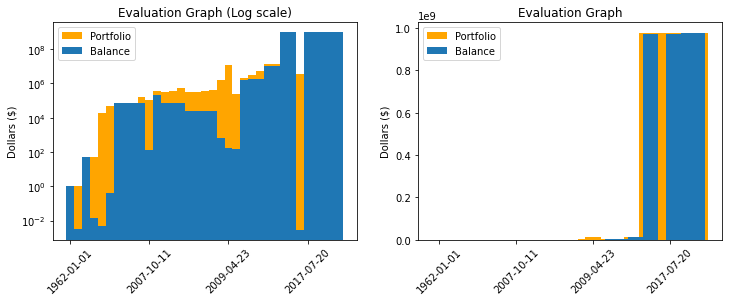

In [64]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the balance and portfolio lists on the first subplot using a logarithmic scale
ax1.bar(dates, portfolio_lst, width=1, label='Portfolio', color='#FFA500')
ax1.bar(dates, balance_lst, width=1,label='Balance', color='#1f77b4')

# Set the title of the first subplot
ax1.set_title('Evaluation Graph (Log scale)')
ax1.set_ylabel('Dollars ($)')

ax1.set_yscale('log')
ax1.legend()

# Plot the balance and portfolio lists on the second subplot using a linear scale
ax2.bar(dates, portfolio_lst, width=2, label='Portfolio', color='#FFA500')
ax2.bar(dates, balance_lst, width=1,label='Balance', color='#1f77b4')

# Set the title of the second subplot
ax2.set_title('Evaluation Graph')
ax2.set_ylabel('Dollars ($)')

ax2.legend()

# Select every 10th element in the dates list
tick_indices = np.arange(0, len(dates), 10)
tick_labels = [dates[i] for i in tick_indices]

# Rotate the x-axis tick labels on both subplots
for ax in (ax1, ax2):
    ax.set_xticks(tick_indices, tick_labels, rotation=45)

# Show the plot
plt.show()

## Make money using a large amount of transanctions

In [65]:
actions_la, portfolio_la = make_money(start_date='1962-01-01', end_date='2017-11-10', balance=1, N=200)

 99%|█████████▉| 198/200 [02:53<00:01,  1.14it/s]


In [66]:
actions_la

,Date,Action,Stock,Amount,Rem_balance,Value
0,1962-01-08,buy-low,GE,1,0.4284,0.5716
1,1962-02-15,sell-high,GE,1,1.0804,0.6520
2,1962-11-07,buy-low,GE,1,0.5088,0.5716
3,1963-01-10,sell-close,GE,1,1.169,0.6602
4,1963-03-06,buy-low,GE,1,0.5733,0.5957
...,...,...,...,...,...,...
5483,2017-11-10,sell-high,HGSH,3225,3251562019.791538,1.8800
5484,2017-11-10,sell-high,KINS,37068,3252223683.591538,17.8500
5485,2017-11-10,sell-high,PPC,33277,3253388378.591538,35.0000
5486,2017-11-10,sell-high,NVDA,4990,3254479541.891538,218.6700


In [67]:
# print(actions_la.to_string(index=False))

## Save to txt format

In [69]:
get_txt(actions_la, name= 'large.txt')

### Create Plots

In [70]:
# Get unique values (dates) for plotting purposes
uniq_actions_la = actions_la.drop_duplicates(subset=['Date'])
portf_value_la = get_portfolio_value(portfolio_la, files_filtered)
portf_fin_la = uniq_actions_la['Rem_balance'].values + np.asarray(portf_value_la)

# Get lists
portfolio_lst_la = portf_fin_la.tolist()
portfolio_lst_la.insert(0,1) # Just because of the way we have implement it we need to add 1 at first to initialize it
dates_la = uniq_actions_la['Date'].to_list()
dates_la.insert(0, '1962-01-01')
balance_lst_la = uniq_actions_la['Rem_balance'].to_list()
balance_lst_la.insert(0,1) # Just because of the way we have implement it we need to add 1 at first to initialize it

/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


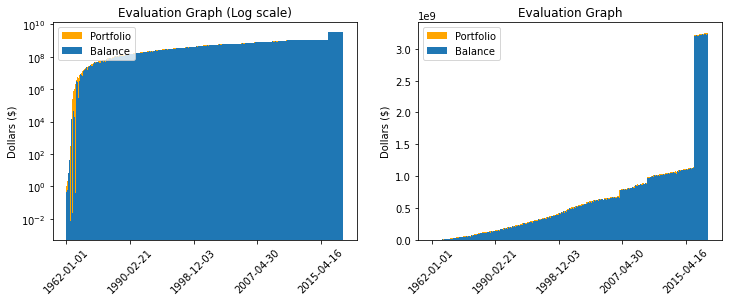

In [71]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the balance and portfolio lists on the first subplot using a logarithmic scale
ax1.bar(dates_la, portfolio_lst_la, width=1, label='Portfolio', color='#FFA500')
ax1.bar(dates_la, balance_lst_la, width=1,label='Balance', color='#1f77b4')

# Set the title of the first subplot
ax1.set_title('Evaluation Graph (Log scale)')
ax1.set_ylabel('Dollars ($)')

ax1.set_yscale('log')
ax1.legend()

# Plot the balance and portfolio lists on the second subplot using a linear scale
ax2.bar(dates_la, portfolio_lst_la, width=1, label='Portfolio', color='#FFA500')
ax2.bar(dates_la, balance_lst_la, width=1,label='Balance', color='#1f77b4')

# Set the title of the second subplot
ax2.set_title('Evaluation Graph')
ax2.set_ylabel('Dollars ($)')

ax2.legend()

# Select every 10th element in the dates list
tick_indices = np.arange(0, len(dates_la), 1000)
tick_labels = [dates_la[i] for i in tick_indices]

# Rotate the x-axis tick labels on both subplots
for ax in (ax1, ax2):
    ax.set_xticks(tick_indices, tick_labels, rotation=45)

# Show the plot
plt.show()

# FIN